In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import io
from PIL import Image
import torch.nn.functional as F
import math
from sklearn.model_selection import GroupShuffleSplit

In [2]:
RANDOM = 42

In [3]:
torch.manual_seed(RANDOM)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name()}")

Using cuda device
GPU: NVIDIA GeForce RTX 3060


# Data

In [5]:
training_data_path = Path("data/CMI/train.csv")
training_data_demo_path = Path("data/CMI/train_demographics.csv")

test_data_path = Path("data/CMI/test.csv")
test_data_demo_path = Path("data/CMI/test_demographics.csv")


train_df = pd.read_csv(training_data_path)
train_demo_df = pd.read_csv(training_data_demo_path)
test_df = pd.read_csv(test_data_path)
test_demo_df = pd.read_csv(test_data_demo_path)


In [6]:
train_df.head(10)

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,101.0,111.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,101.0,109.0,125.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,SEQ_000007_000005,Target,SEQ_000007,5,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,3.996094,...,-1.0,-1.0,118.0,114.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,SEQ_000007_000006,Target,SEQ_000007,6,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,4.035156,...,-1.0,-1.0,104.0,118.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,SEQ_000007_000007,Target,SEQ_000007,7,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,3.730469,...,-1.0,-1.0,105.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,SEQ_000007_000008,Target,SEQ_000007,8,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,4.535156,...,-1.0,-1.0,103.0,122.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,SEQ_000007_000009,Target,SEQ_000007,9,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,3.921875,...,-1.0,-1.0,104.0,123.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


# Dataset

inne podejscie do budowania datasetu, fit transform tylko na trainie.

In [7]:
class CMIIMUDataset(Dataset):
    def __init__(self, df:pd.DataFrame, feature_cols:list[str] ,label_col:str, transform=None, device:str='cpu') -> None:
        super().__init__()
        self.device = device
        self.df = df
        self.transform = transform
        self.feature_cols = feature_cols
        self.label_col = label_col
        self.sequences = []
        self.lengths = []
        self.labels = []

        #Build sequences
        for seq_id, group in df.groupby("sequence_id"):
            data = group[self.feature_cols].copy()
            data = pd.DataFrame(data).ffill().bfill().fillna(0).values  # (L, D)
            if self.transform is not None:
                data = self.transform(data)
            seq_t = torch.as_tensor(data, dtype=torch.float32)
            self.sequences.append(seq_t)
            self.lengths.append(seq_t.size(0))
        
        self.labels = self.df.groupby('sequence_id')['gesture'].first().values
        self.labels = torch.as_tensor(self.labels, dtype=torch.long)

        self.sequence_types = self.df.groupby('sequence_id')['sequence_type'].first().values

    def get_input_dim(self) -> int:
        assert len(self.sequences) > 0, "Empty dataset"
        return int(self.sequences.shape)

    def get_num_classes(self) -> int:
        return int(torch.unique(self.labels).numel())

    def get_max_len(self) -> int:
        return int(max(self.lengths))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.lengths[idx], self.labels[idx]

In [8]:
def collate(batch, device='cpu'):
    # batch: list of (seq [Li,D], length Li, label)
    seqs, lengths, labels = zip(*batch)
    lengths = torch.as_tensor(lengths, dtype=torch.long)                 # [N]
    labels = torch.as_tensor(labels, dtype=torch.long)                   # [N]
    padded = nn.utils.rnn.pad_sequence(seqs, batch_first=True)           # [N, L, D]
    N, L, _ = padded.shape
    # mask: True na padach
    positions = torch.arange(L).unsqueeze(0).expand(N, L)                # [N, L]
    src_key_padding_mask = positions >= lengths.unsqueeze(1)             # [N, L], bool
    # przenieś na device
    return (padded.to(device), src_key_padding_mask.to(device), lengths.to(device)), labels.to(device)

## Train, Val split

In [9]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM)
groups = train_df["sequence_id"]
y = train_df["gesture"]
train_idx, val_idx = next(gss.split(train_df, y=y, groups=groups))
df_train = train_df.iloc[train_idx].reset_index(drop=True)
df_val   = train_df.iloc[val_idx].reset_index(drop=True)

In [10]:
le = LabelEncoder()
df_train["gesture"] = le.fit_transform(df_train["gesture"])
df_val["gesture"]   = le.transform(df_val["gesture"])

In [11]:
excluded_cols = {
            'gesture', 'sequence_type', 'behavior', 'orientation',  # train-only
            'row_id', 'subject', 'phase',  # metadata
            'sequence_id', 'sequence_counter'  # identifiers
        }
        
thermal_tof_cols = [col for col in df_train.columns if col.startswith('thm_') or col.startswith('tof_')]
excluded_cols.update(thermal_tof_cols)

In [12]:
feature_cols = [c for c in df_train.columns if c not in excluded_cols]
Xtrain2d = pd.DataFrame(df_train[feature_cols]).ffill().bfill().fillna(0).values
scaler = StandardScaler().fit(Xtrain2d)

In [13]:
def seq_transform(x_ndarray):
    return scaler.transform(x_ndarray)

In [14]:
train_set = CMIIMUDataset(df_train, feature_cols, label_col="gesture", transform=seq_transform, device="cuda")
val_set   = CMIIMUDataset(df_val,   feature_cols, label_col="gesture", transform=seq_transform, device="cuda")

In [15]:
train_set[:1]

([tensor([[ 0.8767,  0.8824,  0.6236, -0.9999, -0.5130, -0.7091, -1.2337],
          [ 0.9226,  0.8824,  0.5858, -0.9597, -0.4810, -0.6747, -1.2630],
          [ 0.7105,  0.7218,  0.9624, -0.6252, -0.3394, -0.5427, -1.3447],
          [ 0.8625,  0.3468,  1.1321, -0.2779, -0.3178, -0.3242, -1.3851],
          [ 0.6835, -0.3026,  1.6529, -0.1185, -0.2201, -0.0029, -1.4424],
          [ 0.4120, -0.4858,  1.6663, -0.0039, -0.2002,  0.1089, -1.4315],
          [ 0.4188, -0.7610,  1.5908,  0.0838, -0.2301,  0.1225, -1.4087],
          [ 0.3661, -0.7228,  1.5664,  0.0790, -0.2437,  0.1171, -1.4065],
          [ 0.5052, -0.7306,  1.5280,  0.0512, -0.2521,  0.1157, -1.4098],
          [ 0.3992, -0.6776,  1.5594,  0.0417, -0.2479,  0.1226, -1.4125],
          [ 0.4654, -0.7158,  1.5280,  0.0350, -0.2479,  0.1234, -1.4138],
          [ 0.4519, -0.7462,  1.5209,  0.0401, -0.2141,  0.1180, -1.4206],
          [ 0.3661, -0.6620,  1.5722,  0.0622, -0.2030,  0.1076, -1.4189],
          [ 0.3789, -0.63

In [16]:
def get_dataloaders(train_set, val_set, batch_size=1024):
    if train_set is not None:
        train_loader = DataLoader(
            train_set, batch_size=batch_size, shuffle=True,
            collate_fn=lambda b: collate(b, device="cuda")
        )
    else:
        train_loader = None

    if val_set is not None:
        val_loader = DataLoader(
            val_set, batch_size=batch_size, shuffle=False,
            collate_fn=lambda b: collate(b, device="cuda")
        )
    else:
        val_loader = None
    return train_loader, val_loader

# Transformer models

## Base

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 2048, batch_first: bool = True):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.batch_first = batch_first
        self.register_buffer("pe", self._build_pe(d_model, max_len))  # [max_len, 1, d_model]

    @staticmethod
    def _build_pe(d_model: int, max_len: int) -> torch.Tensor:
        pe = torch.zeros(max_len, 1, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        return pe

    def maybe_extend(self, needed_len: int):
        if needed_len <= self.pe.size(0):
            return
        new_pe = self._build_pe(self.pe.size(2), needed_len).to(self.pe.device, dtype=self.pe.dtype)
        self.pe = new_pe  # zaktualizuj buffer

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        L = x.size(1) if self.batch_first else x.size(0)
        self.maybe_extend(L)
        if self.batch_first:
            x = x + self.pe[:L].transpose(0, 1)  # [1, L, d_model]
        else:
            x = x + self.pe[:L]                   # [L, 1, d_model]
        return self.dropout(x)


class TransformerClassifier(nn.Module):
    def __init__(
        self,
        input_dim: int,      # D
        num_classes: int,    # C
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 1,
        dim_feedforward: int = 128,
        dropout: float = 0.1,
        max_len: int = 2048,
    ):
        super().__init__()
        assert d_model % nhead == 0, "d_model musi być podzielne przez nhead"
        self.proj = nn.Linear(input_dim, d_model)
        self.pos = PositionalEncoding(d_model, max_len=max_len, dropout=dropout, batch_first=True)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True, 
            activation="gelu",
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes),
        )

    def forward(self, x: torch.Tensor, key_padding_mask: torch.Tensor | None = None):
        # x: [N, L, D], mask: [N, L] (True na padding)
        x = self.proj(x)         # [N, L, d_model]
        x = self.pos(x)          # + sinusoidal PE
        x = self.enc(x, src_key_padding_mask=key_padding_mask)  # [N, L, d_model]
        x = x.mean(dim=1)        # mean pooling po czasie -> [N, d_model]
        logits = self.head(x)    # [N, C]
        return logits


## Base + CLS

In [18]:
class PositionalEncodingv2(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 2048, batch_first: bool = True):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.batch_first = batch_first
        self.register_buffer("pe", self._build_pe(d_model, max_len))  # [max_len, 1, d_model]

    @staticmethod
    def _build_pe(d_model: int, max_len: int) -> torch.Tensor:
        pe = torch.zeros(max_len, 1, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        return pe

    def maybe_extend(self, needed_len: int):
        if needed_len <= self.pe.size(0):
            return
        new_pe = self._build_pe(self.pe.size(2), needed_len).to(self.pe.device, dtype=self.pe.dtype)
        self.pe = new_pe  # zaktualizuj buffer

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        L = x.size(1) if self.batch_first else x.size(0)
        self.maybe_extend(L)
        if self.batch_first:
            x = x + self.pe[:L].transpose(0, 1)  # [1, L, d_model]
        else:
            x = x + self.pe[:L]                   # [L, 1, d_model]
        return self.dropout(x)


class TransformerClassifierv2(nn.Module):
    def __init__(
        self,
        input_dim: int,      # D
        num_classes: int,    # C
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 1,
        dim_feedforward: int = 128,
        dropout: float = 0.1,
        max_len: int = 2048,
    ):
        super().__init__()
        assert d_model % nhead == 0, "d_model musi być podzielne przez nhead"
        self.proj = nn.Linear(input_dim, d_model)
        self.pos = PositionalEncodingv2(d_model, max_len=max_len, dropout=dropout, batch_first=True)

        # CLS token (learnable)
        self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.normal_(self.cls, mean=0.0, std=0.02)
        
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True, 
            activation="gelu",
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes),
        )

    def forward(self, x: torch.Tensor, key_padding_mask: torch.Tensor | None = None):
        # x: [N, L, D], mask: [N, L] (True na padding)
        x = self.proj(x)                               # [N, L, d_model]
        x = self.pos(x)                                # + PE
        N = x.size(0)
        cls_tok = self.cls.expand(N, 1, -1)            # [N,1,d_model]
        x = torch.cat([cls_tok, x], dim=1)             # [N, L+1, d_model]
        if key_padding_mask is not None:
            pad_false = torch.zeros((N, 1), dtype=key_padding_mask.dtype, device=key_padding_mask.device)
            key_padding_mask = torch.cat([pad_false, key_padding_mask], dim=1)  # [N, L+1]
        x = self.enc(x, src_key_padding_mask=key_padding_mask)  # [N, L+1, d_model]
        x = x[:, 0, :]                                 # reprezentacja CLS [N, d_model]
        logits = self.head(x)                          # [N, C]
        return logits


## Leanrable PE + CLS

In [19]:
class LearnablePE(nn.Module):
    def __init__(self, d_model, max_len=2048, batch_first=True):
        super().__init__()
        self.batch_first = batch_first
        self.pe = nn.Parameter(torch.zeros(max_len, 1, d_model))
        nn.init.normal_(self.pe, std=0.02)

    def maybe_extend(self, needed):
        if needed <= self.pe.size(0): return
        extra = needed - self.pe.size(0)
        add = nn.Parameter(torch.zeros(extra, 1, self.pe.size(2), device=self.pe.device))
        nn.init.normal_(add, std=0.02)
        self.pe = nn.Parameter(torch.cat([self.pe, add], dim=0))

    def forward(self, x):
        L = x.size(1) if self.batch_first else x.size(0)
        self.maybe_extend(L)
        return x + (self.pe[:L].transpose(0,1) if self.batch_first else self.pe[:L])



class TransformerClassifierv3(nn.Module):
    def __init__(
        self,
        input_dim: int,      # D
        num_classes: int,    # C
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 1,
        dim_feedforward: int = 128,
        dropout: float = 0.1,
        max_len: int = 2048,
    ):
        super().__init__()
        assert d_model % nhead == 0, "d_model musi być podzielne przez nhead"
        self.proj = nn.Linear(input_dim, d_model)
        self.pos = LearnablePE(d_model, max_len=max_len, batch_first=True)

        # CLS token (learnable)
        self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.normal_(self.cls, mean=0.0, std=0.02)
        
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True, 
            activation="gelu",
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes),
        )

    def forward(self, x: torch.Tensor, key_padding_mask: torch.Tensor | None = None):
        # x: [N, L, D], mask: [N, L] (True na padding)
        x = self.proj(x)                               # [N, L, d_model]
        x = self.pos(x)                                # + PE
        N = x.size(0)
        cls_tok = self.cls.expand(N, 1, -1)            # [N,1,d_model]
        x = torch.cat([cls_tok, x], dim=1)             # [N, L+1, d_model]
        if key_padding_mask is not None:
            pad_false = torch.zeros((N, 1), dtype=key_padding_mask.dtype, device=key_padding_mask.device)
            key_padding_mask = torch.cat([pad_false, key_padding_mask], dim=1)  # [N, L+1]
        x = self.enc(x, src_key_padding_mask=key_padding_mask)  # [N, L+1, d_model]
        x = x[:, 0, :]                                 # reprezentacja CLS [N, d_model]
        logits = self.head(x)                          # [N, C]
        return logits


## LPE, CLS, better head

* Private Score - 0.668165
* Public Score - 0.658864

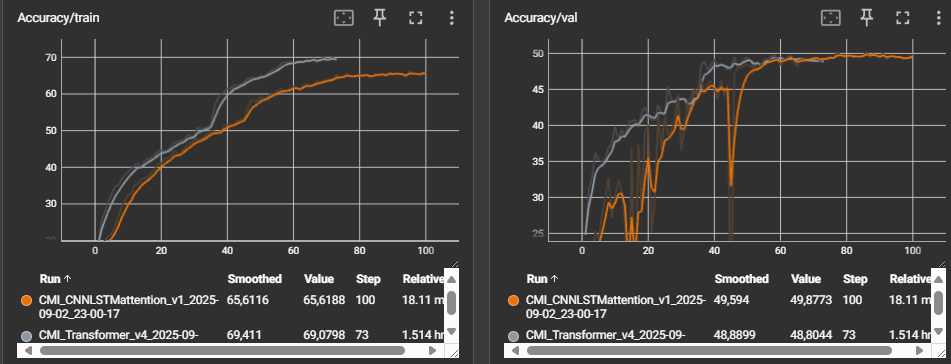

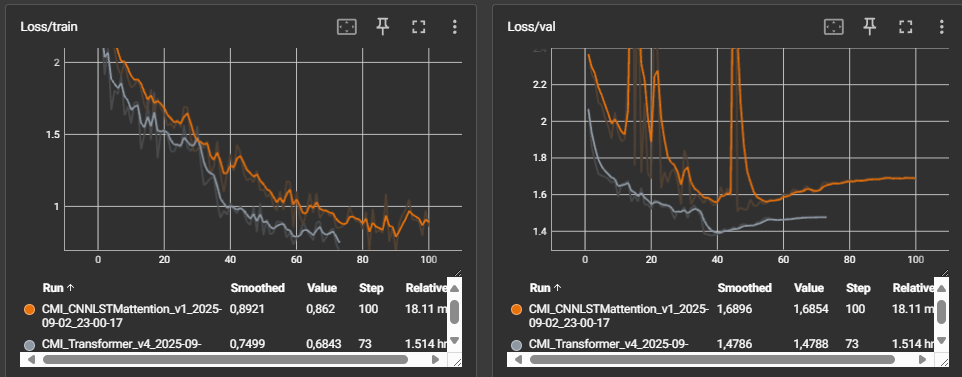

In [20]:
class TransformerClassifierv4(nn.Module):
    def __init__(
        self,
        input_dim: int,      # D
        num_classes: int,    # C
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 1,
        dim_feedforward: int = 128,
        dropout: float = 0.1,
        max_len: int = 2048,
    ):
        super().__init__()
        assert d_model % nhead == 0, "d_model musi być podzielne przez nhead"
        self.proj = nn.Linear(input_dim, d_model)
        self.pos = LearnablePE(d_model, max_len=max_len, batch_first=True)

        # CLS token (learnable)
        self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.normal_(self.cls, mean=0.0, std=0.02)
        
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True, 
            activation="gelu",
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(d_model * 2),
            nn.Linear(d_model * 2, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes),
        )


    def forward(self, x: torch.Tensor, key_padding_mask: torch.Tensor | None = None):
        # x: [N, L, D], mask: [N, L] (True na padding)
        x = self.proj(x)                               # [N, L, d_model]
        x = self.pos(x)                                # + PE
        N = x.size(0)
        cls_tok = self.cls.expand(N, 1, -1)            # [N,1,d_model]
        x = torch.cat([cls_tok, x], dim=1)             # [N, L+1, d_model]
        if key_padding_mask is not None:
            pad_false = torch.zeros((N, 1), dtype=key_padding_mask.dtype, device=key_padding_mask.device)
            key_padding_mask = torch.cat([pad_false, key_padding_mask], dim=1)  # [N, L+1]
        x = self.enc(x, src_key_padding_mask=key_padding_mask)  # [N, L+1, d_model]
        x = x[:, 0, :]                                 # reprezentacja CLS [N, d_model]
        logits = self.head(x)                          # [N, C]
        return logits


# Competition Metric

In [21]:
class CompetitionMetric:
    """Hierarchical macro F1 for the CMI 2025 challenge."""
    def __init__(self):
        self.target_gestures = [
            'Above ear - pull hair',
            'Cheek - pinch skin',
            'Eyebrow - pull hair',
            'Eyelash - pull hair',
            'Forehead - pull hairline',
            'Forehead - scratch',
            'Neck - pinch skin',
            'Neck - scratch',
        ]
        self.non_target_gestures = [
            'Write name on leg',
            'Wave hello',
            'Glasses on/off',
            'Text on phone',
            'Write name in air',
            'Feel around in tray and pull out an object',
            'Scratch knee/leg skin',
            'Pull air toward your face',
            'Drink from bottle/cup',
            'Pinch knee/leg skin'
        ]
        self.all_classes = self.target_gestures + self.non_target_gestures

    def calculate_hierarchical_f1(
        self,
        sol: pd.DataFrame,
        sub: pd.DataFrame
    ) -> float:
        # Validate gestures
        invalid_types = {i for i in sub['gesture'].unique() if i not in self.all_classes}
        if invalid_types:
            raise ValueError(f"Invalid gesture values in submission: {invalid_types}")

        # Compute binary F1 (Target vs Non-Target)
        y_true_bin = sol['gesture'].isin(self.target_gestures).values
        y_pred_bin = sub['gesture'].isin(self.target_gestures).values
        f1_binary = f1_score(
            y_true_bin,
            y_pred_bin,
            pos_label=True,
            zero_division=0,
            average='binary'
        )

        # Build multi-class labels for gestures
        y_true_mc = sol['gesture'].apply(lambda x: x if x in self.target_gestures else 'non_target')
        y_pred_mc = sub['gesture'].apply(lambda x: x if x in self.target_gestures else 'non_target')

        # Compute macro F1 over all gesture classes
        f1_macro = f1_score(
            y_true_mc,
            y_pred_mc,
            average='macro',
            zero_division=0
        )

        return 0.5 * f1_binary + 0.5 * f1_macro

# Training

In [22]:
def calculate_training_metrics(predictions, labels):
    accuracy = (predictions == labels).mean()
    precision = precision_score(y_true=labels, y_pred=predictions, average='weighted', zero_division=0)
    recall = recall_score(y_true=labels, y_pred=predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_true=labels, y_pred=predictions, average='weighted', zero_division=0)

    # Add tp, fp, fn, tn calculations for each class
    cm = confusion_matrix(labels, predictions)
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (tp + fp + fn)

    return accuracy, precision, recall, f1, cm, tp, fp, fn, tn, labels, predictions

In [23]:
def train_one_epoch(train_loader, model, loss_fn, optimizer, epoch_idx):
    running_loss = 0.0
    last_loss = 0.0
    quarter = max(1, len(train_loader) // 4) # log every 1/4 of an epoch
    n_in_window = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []

    for i, batch in enumerate(train_loader):
        # batch pochodzi z collate_fn: ((padded, mask, lengths), labels)
        (inputs, src_key_padding_mask, lengths), labels = batch  # rozpakowanie [2]
        inputs = inputs.to(device)                               # [N, L, D] [1]
        labels = labels.to(device)                               # [N] [1]
        src_key_padding_mask = src_key_padding_mask.to(device)   # [N, L] bool [3]

        optimizer.zero_grad()

        # forward z maską (Transformery)
        outputs = model(inputs, key_padding_mask=src_key_padding_mask)  # logits [N, C] [3]
        logits = outputs  # już [N, C]; brak permute/mean [3]

        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        # akumulacja strat i metryk
        running_loss += loss.item()
        n_in_window += 1

        probabilities = torch.softmax(logits, dim=1)
        predicted = logits.argmax(dim=1)

        all_predictions.extend(predicted.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        all_probabilities.extend(probabilities.detach().cpu().numpy())

        if ((i + 1) % quarter == 0) or ((i + 1) == len(train_loader)):
            last_loss = running_loss / n_in_window  # średnia w oknie
            pct = int(round(100 * (i + 1) / len(train_loader)))
            print(f"  epoch {epoch_idx+1} {pct}% ({i+1}/{len(train_loader)}) - loss: {last_loss:.6f}")

            # reset okna
            running_loss = 0.
            n_in_window = 0

    # Calculate metrics at the end of epoch
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)
    metrics = calculate_training_metrics(all_predictions, all_labels)

    return last_loss, metrics


In [24]:
class EarlyStopping_Accuracy:
    """Early stops the training if validation accuracy doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation accuracy improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation accuracy improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_accuracy_max = 0.0
        self.delta = delta
        self.path = path

    def __call__(self, val_accuracy, model, epoch):

        score = val_accuracy

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model, epoch)
            self.counter = 0

    def save_checkpoint(self, val_accuracy, model, epoch):
        '''Saves model when validation accuracy increases.'''
        if self.verbose:
            print(f'Validation accuracy increased ({self.val_accuracy_max:.6f} --> {val_accuracy:.6f}) at epoch {epoch}.  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_accuracy_max = val_accuracy

In [25]:
def validate(val_loader: DataLoader, model: nn.Module, loss_fn: nn.Module, device="cuda"):
    model.eval()  # BN/Dropout w trybie ewaluacji [4]
    running_loss = 0.0
    n_in_window = 0

    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():  # bez autograd dla szybkości i pamięci [1][13]
        for i, batch in enumerate(val_loader):
            # batch: ((inputs, src_key_padding_mask, lengths), labels) [2]
            (inputs, src_key_padding_mask, lengths), labels = batch
            inputs = inputs.to(device)                        # [N, L, D] [21]
            labels = labels.to(device)                        # [N]
            src_key_padding_mask = src_key_padding_mask.to(device)  # [N, L] bool [20]

            # forward z maską → logits [N, C] [20]
            logits = model(inputs, key_padding_mask=src_key_padding_mask)

            loss = loss_fn(logits, labels)
            running_loss += loss.item()
            n_in_window += 1

            probs = torch.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)

            all_predictions.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
            all_probabilities.extend(probs.detach().cpu().numpy())

    all_predictions = np.asarray(all_predictions)
    all_labels = np.asarray(all_labels)
    all_probabilities = np.asarray(all_probabilities)

    metrics = calculate_training_metrics(all_predictions, all_labels)
    avg_loss = running_loss / max(1, n_in_window)

    print(f"  Validation - loss: {avg_loss:.6f}, accuracy: {metrics[0]*100:.2f}%, precision: {metrics[1]:.4f}, recall: {metrics[2]:.4f}, f1: {metrics[3]:.4f}")

    return avg_loss, metrics, all_probabilities


In [26]:
def write_to_tensorboard(writer, epoch, train_loss, val_loss, val_metrics, train_metrics, learning_rate):
    # val_metrics: accuracy, precision, recall, f1, cm, tp, fp, fn, tn, labels, predictions
    #               0           1           2   3   4   5    6   7   8      9       10
    # train_metrics: accuracy, precision, recall, f1, cm, tp, fp, fn, tn, labels, predictions
    writer.add_scalar('Loss/train', train_loss, epoch + 1)
    writer.add_scalar('Loss/val', val_loss, epoch + 1)
    writer.add_scalars('Loss', {'Training': train_loss, 'Validation': val_loss}, epoch + 1)
    writer.add_scalar('Accuracy/val', val_metrics[0]*100, epoch + 1)
    writer.add_scalar('Precision/val', val_metrics[1], epoch + 1)
    writer.add_scalar('Recall/val', val_metrics[2], epoch + 1)
    writer.add_scalar('F1-score/val', val_metrics[3], epoch + 1)
    writer.add_scalar('Accuracy/train', train_metrics[0]*100, epoch + 1)
    writer.add_scalar('Precision/train', train_metrics[1], epoch + 1)
    writer.add_scalar('Recall/train', train_metrics[2], epoch + 1)
    writer.add_scalar('F1-score/train', train_metrics[3], epoch + 1)
    writer.add_scalar('Learning Rate', learning_rate, epoch + 1)

    writer.flush()

In [27]:
def train_loop(train_data: Subset, val_data: Subset, model: nn.Module, loss_fn: nn, optimizer: torch.optim, scheduler: torch.optim.lr_scheduler, name: str, patience=10, epochs=10, batch_size=32, warmup_epochs=0, warmup_lr=1e-5):
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    writer = SummaryWriter('runs/{}_{}'.format(name, timestamp))

    early_stopping = EarlyStopping_Accuracy(patience=patience, verbose=True, path='runs/{}_{}/best_accuracy_model.pt'.format(name, timestamp))
    epoch_number = 0

    all_metrics = []
    all_vmetrics = []
    all_probabilities = []

    best_vloss = 1_000_000.
    best_vloss_epoch = -1

    train_dataloader, validation_loader = get_dataloaders(train_data, val_data, batch_size=batch_size)

    for epoch in range(epochs):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss, metrics = train_one_epoch(train_dataloader, model, loss_fn, optimizer, epoch_number)

        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        avg_vloss, vmetrics, probabilities = validate(validation_loader, model, loss_fn)

        # Step the scheduler
        if epoch_number < warmup_epochs:
            # Linear warmup
            warmup_lr = (epoch_number + 1) / warmup_epochs * optimizer.defaults['lr']
            for param_group in optimizer.param_groups:
                param_group['lr'] = warmup_lr
            print(f"  Warmup LR: {warmup_lr:.6f}")
        else:
            scheduler.step(vmetrics[0])  # Step based on validation accuracy

        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        write_to_tensorboard(writer, epoch_number, avg_loss, avg_vloss, vmetrics, metrics, 
                           optimizer.param_groups[0]['lr'])

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            best_vloss_epoch = epoch_number
            model_path = 'runs/{}_{}/best_loss_model.pt'.format(name, timestamp)
            torch.save(model.state_dict(), model_path)

        all_metrics.append(metrics)
        all_vmetrics.append(vmetrics)
        all_probabilities.append(probabilities)

        # Early stopping
        early_stopping(vmetrics[0], model, epoch_number) # Monitor validation accuracy
        if early_stopping.early_stop:
            print("Early stopping")
            break

        epoch_number += 1

    print("Training complete.")
    print(f"Best validation loss: {best_vloss:.6f} at epoch {best_vloss_epoch + 1}")

    data = {
        "model": model,
        "writer": writer,
        "all_metrics": all_metrics,
        "all_vmetrics": all_vmetrics,
        "all_probabilities": all_probabilities,
        "model_path": 'runs/{}_{}'.format(name, timestamp)
    }
    return data

In [28]:
def evaluate_model(model, val_data, batch_size=128):
    """
    Evaluate model on validation data, calculating both standard and competition metrics
    """
    model.eval()
    _, val_loader = get_dataloaders(None,val_data, batch_size=batch_size)
    
    all_predictions = []
    all_probabilities = []
    all_true_labels = []
    
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            # batch: ((inputs, src_key_padding_mask, lengths), labels) [2]
            (inputs, src_key_padding_mask, lengths), labels = batch
            inputs = inputs.to(device)                        # [N, L, D] [21]
            labels = labels.to(device)                        # [N]
            src_key_padding_mask = src_key_padding_mask.to(device)  # [N, L] bool [20]

            # forward z maską → logits [N, C] [20]
            logits = model(inputs, key_padding_mask=src_key_padding_mask)

            probs = torch.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
            
            all_predictions.extend(preds.cpu().numpy())
            all_probabilities.extend(probs.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
    
    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)
    all_true_labels = np.array(all_true_labels)
    
    # Get sequence types for validation samples

    sequence_types = np.asarray(val_data.sequence_types)
    labels = val_data.labels.cpu().numpy() if torch.is_tensor(val_data.labels) else np.asarray(val_data.labels)
    
    # Convert predictions and true labels back to original gesture names
    original_predictions = le.inverse_transform(all_predictions)
    original_labels = le.inverse_transform(all_true_labels)
    
    # Calculate standard metrics
    accuracy = (all_predictions == all_true_labels).mean()
    precision = precision_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
    
    print("\nStandard Metrics:")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Calculate competition metrics using official implementation
    metric = CompetitionMetric()
    val_submission = pd.DataFrame({'gesture': original_predictions})
    val_solution = pd.DataFrame({'gesture': original_labels})
    competition_score = metric.calculate_hierarchical_f1(val_solution, val_submission)
    
    print("\nCompetition Metrics (Official):")
    print(f"Final Score: {competition_score:.4f}")
    
    # Print sequence type statistics
    target_mask = np.isin(original_labels, metric.target_gestures)
    print("\nSequence Statistics:")
    print(f"Target sequences: {target_mask.sum()}")
    print(f"Non-target sequences: {len(target_mask) - target_mask.sum()}")
    
    if target_mask.sum() > 0:
        print("\nTarget gestures present in validation set:")
        target_gestures = np.unique(original_labels[target_mask])
        for gesture in target_gestures:
            print(f"- {gesture}")
    
        # Print confusion matrix for target gestures
        target_indices = np.where(target_mask)[0]
        target_predictions = original_predictions[target_indices]
        target_true_labels = original_labels[target_indices]
        unique_targets = np.unique(target_true_labels)
        
        print("\nConfusion Matrix for Target Gestures:")
        cm = confusion_matrix(target_true_labels, target_predictions, labels=unique_targets)
        print("True labels (rows) vs Predicted labels (columns):")
        print("Labels:", unique_targets)
        print(cm)
    
    return {
        'standard_metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        },
        'competition_score': competition_score,
        'predictions': all_predictions,
        'probabilities': all_probabilities,
        'true_labels': all_true_labels,
        'sequence_types': sequence_types
    }

In [29]:
def plot_pr_curve(y_true, probabilities, writer, class_names=None):
    """
    Rysuje krzywe PR (Precision-Recall) dla każdej klasy.
    
    Args:
        y_true: prawdziwe etykiety
        probabilities: macierz prawdopodobieństw dla każdej klasy (wynik softmax)
        writer: obiekt SummaryWriter z TensorBoard
        class_names: opcjonalna lista nazw klas
    """ 
    num_classes = probabilities.shape[1]
    
    for i in range(num_classes):
        class_name = class_names[i] if class_names is not None else f"class_{i}"
        
        # Konwertuj etykiety na format binarny (1 dla danej klasy, 0 dla pozostałych)
        y_true_binary = (y_true == i).astype(np.int32)
        
        # Pobierz prawdopodobieństwa dla danej klasy
        class_probs = probabilities[:, i]
        
        # Oblicz precision i recall dla różnych progów
        precision, recall, thresholds = precision_recall_curve(y_true_binary, class_probs)
        
        # Rysuj krzywą PR
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'Class {class_name}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {class_name}')
        plt.grid(True)
        plt.legend()
        
        # Zapisz wykres do bufora i dodaj do TensorBoard
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        
        # Konwertuj bufor na tensor
        img = Image.open(buf)
        img_tensor = torch.from_numpy(np.array(img))
        img_tensor = img_tensor.permute(2, 0, 1)  # HWC -> CHW
        
        # Dodaj wykres do TensorBoard
        writer.add_image(f'PR_Curves/{class_name}', img_tensor, global_step=0)
        
        # Dodaj też surowe dane do interaktywnego wykresu
        writer.add_pr_curve(
            f'PR_Curves_Raw/{class_name}',
            y_true_binary,
            class_probs,
            global_step=0
        )
        
        plt.close()
    
    writer.flush()

## Train

In [38]:
D = 7
num_classes = train_set.get_num_classes()
max_len = train_set.get_max_len()

# hiperparametry
d_model = 256
nhead = 8            # d_model % nhead == 0
num_layers = 4
dim_ff = 1024
dropout = 0.2

model = TransformerClassifierv4(
    input_dim=7,
    num_classes=num_classes,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_ff,
    dropout=dropout,
    max_len=700,
).to(device)


/home/tolek/miniconda3/envs/Nauka-ml/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [31]:
model

TransformerClassifierv4(
  (proj): Linear(in_features=7, out_features=256, bias=True)
  (pos): LearnablePE()
  (enc): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (head): Sequential(
    (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=256, out_features=512, bias=True)
    (2): GELU(approximate='none')
    (3)

In [32]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters: {pytorch_total_params:,}")

Total model parameters: 3,602,706


In [33]:
name = 'CMI_Transformer_v4'
loss_fn = nn.CrossEntropyLoss().to(device)
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=0.1, 
    patience=8,
    min_lr=1e-7
)

# Inicjalizacja wag
def init_transformer_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.LayerNorm):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.padding_idx is not None:
            with torch.no_grad():
                module.weight[module.padding_idx].fill_(0.0)
    elif isinstance(module, nn.Conv1d):
        nn.init.kaiming_uniform_(module.weight, nonlinearity="relu")
        if module.bias is not None:
            nn.init.zeros_(module.bias)

model.apply(init_transformer_weights)


TransformerClassifierv4(
  (proj): Linear(in_features=7, out_features=256, bias=True)
  (pos): LearnablePE()
  (enc): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (head): Sequential(
    (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=256, out_features=512, bias=True)
    (2): GELU(approximate='none')
    (3)

In [34]:
torch.cuda.empty_cache()

In [127]:
# Uruchomienie treningu
results = train_loop(
    model=model,
    train_data=train_set,
    val_data=val_set,
    loss_fn=loss_fn,
    optimizer=optimizer,
    patience=15,
    epochs=100,
    batch_size=64,  # Zwiększony batch size dla lepszej stabilności
    scheduler=scheduler,
    warmup_epochs=15,
    warmup_lr=1e-4,
    name=name
)


EPOCH 1:
  epoch 1 25% (25/102) - loss: 2.923778
  epoch 1 49% (50/102) - loss: 2.482515
  epoch 1 74% (75/102) - loss: 2.350485
  epoch 1 98% (100/102) - loss: 2.268168
  epoch 1 100% (102/102) - loss: 2.243610
  Validation - loss: 2.067808, accuracy: 24.83%, precision: 0.2303, recall: 0.2483, f1: 0.2041
  Warmup LR: 0.000067
LOSS train 2.2436100244522095 valid 2.0678081008104177
Validation accuracy increased (0.000000 --> 0.248314) at epoch 0.  Saving model ...
EPOCH 2:
  epoch 2 25% (25/102) - loss: 2.112170
  epoch 2 49% (50/102) - loss: 2.078481
  epoch 2 74% (75/102) - loss: 2.034099
  epoch 2 98% (100/102) - loss: 2.028957
  epoch 2 100% (102/102) - loss: 1.912064
  Validation - loss: 1.863621, accuracy: 31.02%, precision: 0.3109, recall: 0.3102, f1: 0.2815
  Warmup LR: 0.000133
LOSS train 1.9120635986328125 valid 1.8636208130763128
Validation accuracy increased (0.248314 --> 0.310239) at epoch 1.  Saving model ...
EPOCH 3:
  epoch 3 25% (25/102) - loss: 2.005646
  epoch 3 49% (

In [128]:
# Ewaluacja modelu na zbiorze walidacyjnym
print("\nEwaluacja końcowa modelu:")
evaluation = evaluate_model(model, val_set)


Ewaluacja końcowa modelu:

Standard Metrics:
Accuracy: 48.80%
Precision: 0.4883
Recall: 0.4880
F1 Score: 0.4831

Competition Metrics (Official):
Final Score: 0.6943

Sequence Statistics:
Target sequences: 1021
Non-target sequences: 610

Target gestures present in validation set:
- Above ear - pull hair
- Cheek - pinch skin
- Eyebrow - pull hair
- Eyelash - pull hair
- Forehead - pull hairline
- Forehead - scratch
- Neck - pinch skin
- Neck - scratch

Confusion Matrix for Target Gestures:
True labels (rows) vs Predicted labels (columns):
Labels: ['Above ear - pull hair' 'Cheek - pinch skin' 'Eyebrow - pull hair'
 'Eyelash - pull hair' 'Forehead - pull hairline' 'Forehead - scratch'
 'Neck - pinch skin' 'Neck - scratch']
[[75 12  3 11  4  2 17 11]
 [ 5 37 18 29  8  3  5  6]
 [ 4 22 22 31 18 11  4  6]
 [ 5 23 35 44  5  9  5  4]
 [ 2  8 28  6 35 45  1  1]
 [ 1  6 10  1 19 72  1  2]
 [24 12 12 11  3  4 33 26]
 [19 12 11  3  6 10 36 36]]


In [129]:
plot_pr_curve(results["all_vmetrics"][-1][9], results["all_probabilities"][-1], results["writer"], class_names=le.classes_)

In [39]:
essa = torch.load('runs/CMI_Transformer_v4_2025-09-07_20-06-35/best_accuracy_model.pt')
model.load_state_dict(essa)

<All keys matched successfully>

In [66]:
class GraphOnlyWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model  # nie wywołujemy w forward
    def forward(self, x, key_padding_mask=None):
        # Tylko lekkie, deterministyczne operacje tensorowe (bez dropout/attention)
        # Przykład: dodaj CLS i PE rozmiarowo, ale nie licz atencji
        B, L, D = x.shape
        # pokaż, że byłby concat CLS:
        cls = torch.zeros(B, 1, D, dtype=x.dtype, device=x.device)
        x = torch.cat([cls, x], dim=1)
        # pokaż proste przekształcenie kształtu:
        x = x.view(B, -1)  # spłaszczenie
        return x  # zwróć tensor (bez wywoływania self.model)

def add_graph_no_compute(model, example_x, example_kwargs=None, logdir="runs/graph_no_compute"):
    wrapper = GraphOnlyWrapper(model).eval()
    writer = SummaryWriter(logdir)
    writer.add_graph(wrapper, (example_x,), example_kwargs or {})  # narysuje prosty graf
    writer.close()
    return wrapper

# użycie
device = "cuda" if torch.cuda.is_available() else "cpu"
N, L, D = 1, 256, 7
x = torch.randn(N, L, D, device=device)
kwargs = {'key_padding_mask': torch.zeros(N, L, dtype=torch.bool, device=device)}
_ = add_graph_no_compute(model, x, kwargs, logdir="runs/graph_no_compute")

graph(%self : __torch__.GraphOnlyWrapper,
      %x.1 : Float(1, 256, 7, strides=[1792, 7, 1], requires_grad=0, device=cuda:0)):
  %236 : int = prim::Constant[value=0]() # /tmp/ipykernel_1901/3910409651.py:8:0
  %237 : int = aten::size(%x.1, %236) # /tmp/ipykernel_1901/3910409651.py:8:0
  %B : Long(device=cpu) = prim::NumToTensor(%237)
  %257 : int = aten::Int(%B)
  %245 : int = aten::Int(%B)
  %242 : int = prim::Constant[value=2]() # /tmp/ipykernel_1901/3910409651.py:8:0
  %243 : int = aten::size(%x.1, %242) # /tmp/ipykernel_1901/3910409651.py:8:0
  %D : Long(device=cpu) = prim::NumToTensor(%243)
  %246 : int = aten::Int(%D)
  %247 : int = prim::Constant[value=1]() # /tmp/ipykernel_1901/3910409651.py:10:0
  %248 : int[] = prim::ListConstruct(%245, %247, %246)
  %249 : int = prim::Constant[value=6]() # /tmp/ipykernel_1901/3910409651.py:10:0
  %250 : NoneType = prim::Constant()
  %251 : Device = prim::Constant[value="cuda:0"]() # /tmp/ipykernel_1901/3910409651.py:10:0
  %252 : bool = pri

In [ ]:
def build_input_and_mask_from_pd(sequence_df: pd.DataFrame, feature_cols, seq_transform_infer=None, device="cuda"):

    data = sequence_df[feature_cols].copy()
    data = pd.DataFrame(data).ffill().bfill().fillna(0.0).values  # (L, D) [1]

    if seq_transform_infer is not None:
        data = seq_transform_infer(data)  

    x = torch.as_tensor(data, dtype=torch.float32, device=device).unsqueeze(0)  # [1, L, D]
    L = x.size(1)
    mask = torch.zeros((1, L), dtype=torch.bool, device=device)                 # [1, L], False=valid [2]
    return x, mask

@torch.no_grad()
def predict_sequence(sequence_df: pd.DataFrame, model: torch.nn.Module, feature_cols, label_encoder, seq_transform_infer=None, device="cuda") -> str:
    model.eval()
    x, key_padding_mask = build_input_and_mask_from_pd(
        sequence_df, feature_cols=feature_cols, seq_transform_infer=seq_transform_infer, device=device
    )  # [1, L, D], [1, L] [2]
    logits = model(x, key_padding_mask=key_padding_mask)  # [1, C] (CLS head) [4]
    pred_idx = int(logits.argmax(dim=1).item())

    gesture = str(label_encoder.classes_[pred_idx])
    return gesture


In [ ]:
def predict(sequence: pl.DataFrame, demographics: pl.DataFrame) -> str:

    sequence_pd = sequence.to_pandas()

    predicted_gesture = predict_sequence(
        sequence_pd,
        model=model,
        feature_cols=feature_cols,
        label_encoder=le,
        seq_transform_infer=scaler.transform if scaler is not None else None,
        device='cuda',
    )

    metric = CompetitionMetric()
    if predicted_gesture not in metric.all_classes:
        return "Text on phone"
    return predicted_gesture
